In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import math
from PIL import Image


In [55]:
image_path = '/Users/kailashkumar/Downloads/week4/kai_small_dataset' # small data
labels_limit = 5

In [56]:
labels_df = pd.read_parquet("/Users/kailashkumar/Downloads/week4/easy-500/labels.parquet")
labels_df.head(), labels_df['image_id'].value_counts(), labels_df['class'].value_counts()

(   image_id    x    y  orientation  radius  class
 0         0  269  450     0.000000      17      0
 1         0  533  299     0.663225      45      1
 2         0  539  427     0.610865      46      1
 3         0  365  148     0.488692      45      1
 4         0  472  136     2.426008      40      1,
 image_id
 0      23
 329    23
 342    23
 341    23
 340    23
        ..
 161    23
 160    23
 159    23
 158    23
 499    23
 Name: count, Length: 500, dtype: int64,
 class
 1    5500
 2    5500
 0     500
 Name: count, dtype: int64)

In [57]:
small_df = labels_df[:23*labels_limit]
small_df = small_df.drop('orientation', axis=1)
small_df['width'] = small_df['radius'] *2
small_df['height'] = small_df['radius'] *2
small_df['classes'] = small_df['class']
small_df = small_df.drop('class', axis=1)
small_df = small_df.drop('radius', axis=1)

"""small_df['x'] = small_df['x'] - (small_df['width']/2)
small_df['y'] = small_df['y'] - (small_df['height']/2)"""

small_df[small_df['image_id']==0]

,image_id,x,y,width,height,classes
0,0,269,450,34,34,0
1,0,533,299,90,90,1
2,0,539,427,92,92,1
3,0,365,148,90,90,1
4,0,472,136,80,80,1
5,0,846,448,82,82,1
6,0,613,248,82,82,1
7,0,287,214,96,96,1
8,0,657,387,88,88,1
9,0,752,311,82,82,1


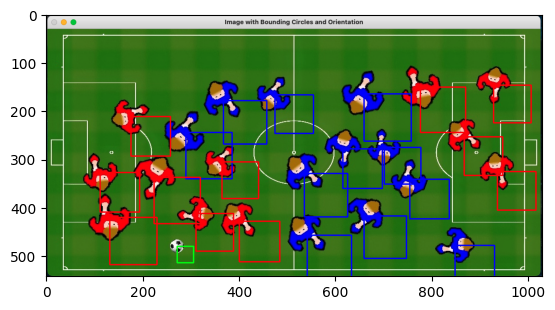

In [58]:
list = small_df.values.tolist()
image_1_labels = list[:23]

image = cv2.imread('/Users/kailashkumar/Downloads/week4/kai_small_dataset/0.jpg')
# Define a dictionary to store the labels for each class
class_labels = {
    0: [],  # Ball
    1: [],  # Team 1
    2: []   # Team 2
    }

# Separate the data into different classes
for id, x, y, width, height, class_id in image_1_labels:
    class_labels[class_id].append((x, y, width, height))

# Define colors for each class
colors = {
    0: (0, 255, 0),   # Green for the ball
    1: (255, 0, 0),   # Blue for Team 1
    2: (0, 0, 255)    # Red for Team 2
}

# Draw bounding circles and orientation lines
for class_id, labels in class_labels.items():
    color = colors[class_id]
    for x, y, width, height in labels:
        # Draw the bounding rectangle
        cv2.rectangle(image, (int(x-(width/2)), int(y-(height/2))), (int(x + width/2), int(y + height/2)), color, 2)

# Display the image with bounding circles and orientation lines
"""cv2.imshow('Image with Bounding Circles and Orientation', image)
cv2.waitKey(0)
cv2.destroyAllWindows()"""

plt.imshow(img.imread('/Users/kailashkumar/Downloads/week4/kai_files/Screenshot 2024-03-27 at 1.46.56 AM.png'));

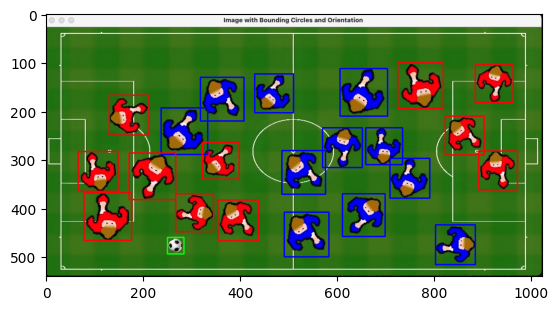

In [59]:
plt.imshow(img.imread('/Users/kailashkumar/Downloads/week4/kai_files/Screenshot 2024-03-27 at 12.11.39 AM.png'));

In [60]:
# Save the DataFrame to a CSV file
csv_file_name = 'annotations.csv'
small_df.to_csv(csv_file_name, index=False)

In [61]:
processed_images = []
processed_annotations = []
adjusted_values_final = []

csv_file = 'annotations.csv'
img_dir = 'kai_small_dataset/'
img_size = 448
S = 3 #grid
C = 3

for i in range(labels_limit):
        target_annotation = np.zeros((S, S, 5 + C))     
        # Load and resize the image
        image_path = os.path.join(img_dir, f"{int(i)}.jpg")
        image = Image.open(image_path)
        original_width, original_height = image.size
        # print(image.size)
        image = image.resize((img_size, img_size))
        # Convert image to numpy array
        image_array = np.array(image)

        # Adjust annotation values
        x_ratio = img_size / original_width
        y_ratio = img_size / original_height

        for _,row in small_df[small_df['image_id'] == i].iterrows():
                x, y, width, height, class_label = row[1:]
                adjusted_x = x * x_ratio
                adjusted_y = y * y_ratio
                adjusted_width = width * x_ratio
                adjusted_height = height * y_ratio
                adjusted_values_final.append((i,adjusted_x,adjusted_y,adjusted_width,adjusted_height, class_label))
                
                # Convert coordinates to grid cell format
                grid_x = int(adjusted_x // (img_size // S))
                grid_y = int(adjusted_y // (img_size // S))
                cell_x = (adjusted_x % (img_size // S)) / (img_size // S)
                cell_y = (adjusted_y % (img_size // S)) / (img_size // S)
                cell_width = adjusted_width / (img_size / S)
                cell_height = adjusted_height / (img_size / S)

                # Create target annotation tensor
                target_annotation[grid_y, grid_x, 0:4] = [cell_x, cell_y, cell_width, cell_height]
                target_annotation[grid_y, grid_x, 4] = 1
                target_annotation[grid_y, grid_x, 5 + int(class_label)] = 1
        
        processed_images.append(image_array)
        processed_annotations.append(target_annotation)
   
processed_images = np.array(processed_images)
processed_annotations = np.array(processed_annotations)
adjusted_values_final = np.array(adjusted_values_final)

# Print the shapes of the processed data
print("Processed Images Shape:", processed_images.shape)
print("Processed Annotations Shape:", processed_annotations.shape)
adjusted_values_final.shape


Processed Images Shape: (5, 448, 448, 3)
Processed Annotations Shape: (5, 3, 3, 8)


(115, 6)

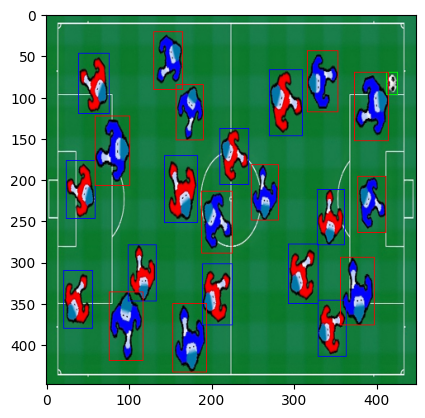

In [63]:
image_count = 2
def plot_labels_on_image(image, labels, class_names=None):
    # Create a copy of the image for drawing
    image_with_labels = image.copy()
    for _, x, y, w, h, class_label in labels:
        # Calculate bounding box coordinates
        x1 = int(x - w/2) 
        y1 = int(y - h/2)
        x2 = int(x + w/2)
        y2 = int(y + h/2) 

        if class_label==0:
            color = (0, 255, 0)
        elif class_label ==1:
            color = (255, 0, 0)
        elif class_label ==2:
            color = (0, 0, 255)

        # Draw the bounding box
        cv2.rectangle(image_with_labels, (x1, y1), (x2, y2), color, 1)

    # Display the image
    plt.imshow(cv2.cvtColor(image_with_labels, cv2.COLOR_BGR2RGB)) 
    plt.show()

plot_labels_on_image(processed_images[image_count], adjusted_values_final[(image_count*23):(image_count*23)+23], class_names)

In [64]:
class YoloDataset(Dataset):
    def __init__(self, images, annotations):
        self.images = images
        self.annotations = annotations
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)
        
        annotation = self.annotations[idx]
        return {'images' : image, 'annotations' : annotation}
    
dataset = YoloDataset(processed_images, processed_annotations)
dataloader = DataLoader(dataset, batch_size=2)

for batch in dataloader:
    images, annotations = batch['images'], batch['annotations']
    print(images.shape)
    print(annotations.shape)

torch.Size([2, 3, 448, 448])
torch.Size([2, 3, 3, 8])
torch.Size([2, 3, 448, 448])
torch.Size([2, 3, 3, 8])
torch.Size([1, 3, 448, 448])
torch.Size([1, 3, 3, 8])


In [65]:
class YOLOv1(nn.Module):
    def __init__(self, num_classes, num_boxes):
        super(YOLOv1, self).__init__()
        self.num_classes = num_classes
        self.num_boxes = num_boxes
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(64, 192, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(192, 128, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 512, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(1024, 512, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 512, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(7*7*1024, 4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, 7*7*(num_boxes*5 + num_classes)),
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        x = x.view(-1, 7, 7, self.num_boxes*5 + self.num_classes)
        return x

def yolo_prediction(model, image, threshold, num_classes):
    model.eval()
    
    with torch.no_grad():
        output = model(image)
        output = output.view(-1, 7, 7, num_boxes*5 + num_classes)
        
        boxes = []
        for i in range(7):
            for j in range(7):
                for b in range(num_boxes):
                    confidence = torch.sigmoid(output[0, i, j, b*5 + 4])
                    if confidence > threshold:
                        x, y, w, h = output[0, i, j, b*5:b*5+4]
                        x = (torch.sigmoid(x) + j) / 7
                        y = (torch.sigmoid(y) + i) / 7
                        w = torch.exp(w) * model.anchors[b][0] / 7
                        h = torch.exp(h) * model.anchors[b][1] / 7
                        class_probs = torch.softmax(output[0, i, j, num_boxes*5:], dim=-1)
                        class_pred = torch.argmax(class_probs)
                        boxes.append([x, y, w, h, confidence, class_pred])
        
        boxes = torch.Tensor(boxes)
        return boxes
    

def yolo_loss(predictions, targets, lambda_coord, lambda_noobj, num_boxes):
    # predictions: (batch_size, 7, 7, num_boxes*5+num_classes)
    # targets: (batch_size, 7, 7, 5+num_classes)
    
    batch_size = predictions.size(0)
    print(f"batch_size{batch_size}")
    
    print(f"num_boxes{num_boxes}")
    print(f"predictions {predictions[-1].shape}")

    coord_mask = targets[..., 4] > 0
    print(f'\nCoord Mask: {coord_mask.shape}\n')
    noobj_mask = targets[..., 4] == 0
    print(f'\nNoobj Mask: {noobj_mask.shape}\n')

    
    coord_predictions = predictions[..., :num_boxes*5].view(batch_size, 7, 7, num_boxes, 5) # 5*7*7*2*5
    coord_targets = targets[..., :5].unsqueeze(-2).expand(batch_size, 7, 7, num_boxes, 5) # 5*7*7*2*5 
    print(f'\ncoord_predictions: {coord_predictions.shape}\n')
    print(f'\ncoord_targets: {coord_targets.shape}\n')
    
    

    box_predictions = coord_predictions[..., :4] # 5*7*7*2*xywhc
    box_targets = coord_targets[..., :4] # 5*7*7*2*xywhc
    print(f'\nbox_predictions: {box_predictions.shape}\n')
    print(f'\nbox_targets: {box_targets.shape}\n')

    
    object_predictions = coord_predictions[..., 4] # 5*7*7*2*C
    object_targets = coord_targets[..., 4]  # 5*7*7*2*C
    print(f'\nobject_predictions: {object_predictions.shape}\n')
    print(f'\nobject_targets: {object_targets.shape}\n')
    
    
    class_predictions = predictions[..., num_boxes*5:] #5*7*7*2*3 c0c1c2
    class_targets = targets[..., 5:] #5*7*7*2*3 c0c1c2
    print(f'\nclass_predictions: {class_predictions.shape}\n')
    print(f'\nclass_targets: {class_targets.shape}\n')
    
    # Find the best bounding box among the predicted boxes
    iou_scores = torch.zeros(batch_size, 7, 7, num_boxes) # 5, 7, 7, 2
    for i in range(num_boxes): #2
        iou_scores[..., i] = calculate_iou(box_predictions[..., i, :], box_targets[..., 0, :])
    best_box_indices = torch.argmax(iou_scores, dim=-1, keepdim=True)
    print(f'\niou_scores: {iou_scores.shape}\n')
    print(f'\nbest_box_indices: {best_box_indices.shape}\n')
    
    # Update the object_targets based on the best bounding box
    object_targets = object_targets.gather(-1, best_box_indices)
    
    coord_mask = coord_mask.unsqueeze(-1).expand_as(box_predictions)
    noobj_mask = noobj_mask.unsqueeze(-1).expand_as(object_predictions)
    
    coord_loss = lambda_coord * torch.sum((box_predictions - box_targets)**2 * coord_mask)
    object_loss = torch.sum((object_predictions - object_targets)**2 * coord_mask)
    noobject_loss = lambda_noobj * torch.sum((object_predictions - 0)**2 * noobj_mask)
    class_loss = torch.sum((class_predictions - class_targets)**2 * coord_mask.squeeze(-1).unsqueeze(-1))
    
    return (coord_loss + object_loss + noobject_loss + class_loss) / batch_size


def calculate_iou(box1, box2):
    # box1: (batch_size, 7, 7, 4)
    # box2: (batch_size, 7, 7, 4)
    
    x1, y1, w1, h1 = box1[..., 0], box1[..., 1], box1[..., 2], box1[..., 3]
    x2, y2, w2, h2 = box2[..., 0], box2[..., 1], box2[..., 2], box2[..., 3]
    
    x_intersect_left = torch.max(x1 - w1/2, x2 - w2/2)
    y_intersect_top = torch.max(y1 - h1/2, y2 - h2/2)
    x_intersect_right = torch.min(x1 + w1/2, x2 + w2/2)
    y_intersect_bottom = torch.min(y1 + h1/2, y2 + h2/2)
    
    intersect_area = torch.clamp(x_intersect_right - x_intersect_left, min=0) * torch.clamp(y_intersect_bottom - y_intersect_top, min=0)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersect_area
    
    iou = intersect_area / (union_area + 1e-6)
    return iou


# Hyperparameters
num_classes = 3
num_boxes = 2
lambda_coord = 5
lambda_noobj = 0.5
num_epochs = 4
learning_rate = 0.001

# Create the YOLOv1 model
model = YOLOv1(num_classes, num_boxes)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in dataloader:
        images, targets = batch['images'], batch['annotations']
        optimizer.zero_grad()
        
        predictions = model(images)
        loss = yolo_loss(predictions, targets, lambda_coord, lambda_noobj, num_boxes)
        
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

batch_size2
num_boxes2
predictions torch.Size([7, 7, 13])

Coord Mask: torch.Size([2, 3, 3])


Noobj Mask: torch.Size([2, 3, 3])



RuntimeError: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 2.  Target sizes: [2, 7, 7, 2, 5].  Tensor sizes: [2, 3, 3, 1, 5]

In [ ]:
def yolo_prediction(model, image, threshold, num_classes):
    model.eval()
    
    with torch.no_grad():
        output = model(image)
        output = output.view(-1, 7, 7, num_boxes*5 + num_classes)
        
        boxes = []
        for i in range(7):
            for j in range(7):
                for b in range(num_boxes):
                    confidence = torch.sigmoid(output[0, i, j, b*5 + 4])
                    if confidence > threshold:
                        x, y, w, h = output[0, i, j, b*5:b*5+4]
                        x = (torch.sigmoid(x) + j) / 7
                        y = (torch.sigmoid(y) + i) / 7
                        w = torch.exp(w) * model.anchors[b][0] / 7
                        h = torch.exp(h) * model.anchors[b][1] / 7
                        class_probs = torch.softmax(output[0, i, j, num_boxes*5:], dim=-1)
                        class_pred = torch.argmax(class_probs)
                        boxes.append([x, y, w, h, confidence, class_pred])
        
        boxes = torch.Tensor(boxes)
        return boxes
    

